# Pierce - Pathway Analysis
Author: Leo Joseph (l1joseph@ucsd.edu)
The purpose of the notebook is to perform pathway  analysis on ASD versus TD samples.

In [1]:
# qiime2 imports
import qiime2 as q2
from qiime2 import Artifact, Metadata, Visualization
from qiime2.plugins.feature_table.methods import filter_features, filter_samples

# birdman imports
import biom
import pandas as pd
import numpy as np

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, leaves_list


## Load Artifacts

In [2]:
ec_tp = biom.load_table('/home/lpatel/projects/2024-03-04_pierce-autism/out/195333_ec.zebra.tp-td.biom')
ec = biom.load_table('/home/lpatel/projects/2024-03-04_pierce-autism/out/195333_ec.zebra.biom')
ko_tp = biom.load_table('/home/lpatel/projects/2024-03-04_pierce-autism/out/195334_ko.zebra.tp-td.biom')
ko = biom.load_table('/home/lpatel/projects/2024-03-04_pierce-autism/out/195334_ko.zebra.biom')
pathway = biom.load_table('/home/lpatel/projects/2024-03-04_pierce-autism/out/195331_pathway.zebra.tp-td.biom')


md = Metadata.load('/home/lpatel/projects/2024-03-04_pierce-autism/qiita/15350_20240110-175840_noblanks.txt')
info = pd.read_csv('/home/lpatel/projects/2024-03-04_pierce-autism/ref/tryptophan_kegg.tsv', sep='\t', index_col=0)



In [3]:
# Convert the EC column values to a set for faster lookup
ec_info_values = set(info["EC"].values)

# Get the observation IDs from the BIOM table `ec`
ec_observation_ids = set(ec.ids(axis='observation'))

# Find the overlap
overlap = ec_info_values.intersection(ec_observation_ids)

# Display the overlap
print(f"Number of overlapping items: {len(overlap)}")
print(f"Overlapping items: {overlap}")


Number of overlapping items: 7
Overlapping items: {'1.4.3.4', '3.7.1.3', '3.5.1.9', '1.13.11.11', '1.13.11.6', '1.14.16.1', '4.1.1.28'}


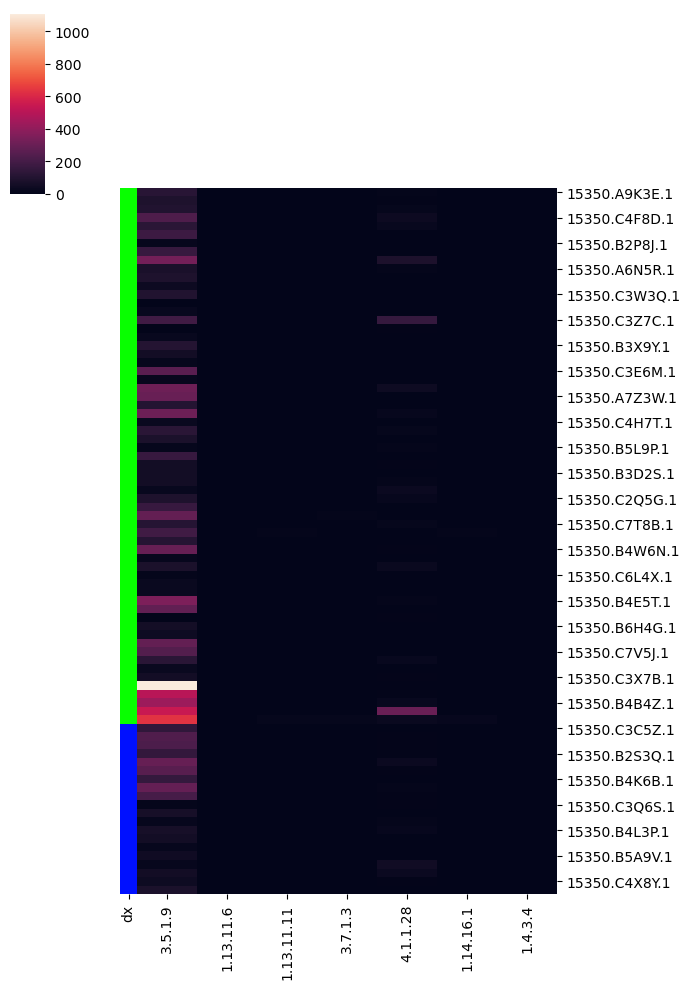

In [5]:
# Convert the EC column values to a set for faster lookup
ec_info_values = set(info["EC"].values)

# Get the observation IDs from the BIOM table `ec`
ec_observation_ids = set(ec.ids(axis='observation'))

# Find the overlap
overlap = ec_info_values.intersection(ec_observation_ids)

# Filter the `ec` table to include only the overlapping observations
filtered_ec = ec.filter(overlap, axis='observation', inplace=False)

# Convert the filtered BIOM table to a DataFrame
filtered_ec_df = filtered_ec.to_dataframe(dense=True).T

# Group samples by the "dx" column from the metadata
metadata_df = md.to_dataframe()
grouped_samples = metadata_df["dx"].loc[filtered_ec_df.index]

# Sort rows by 'dx'
sorted_metadata_df = metadata_df.loc[filtered_ec_df.index].sort_values('dx')
sorted_filtered_ec_df = filtered_ec_df.loc[sorted_metadata_df.index]

# Define clusters for rows (samples) within each 'dx' group
def cluster_within_groups(df, group_labels):
    sorted_idx = []
    unique_groups = group_labels.unique()
    for group in unique_groups:
        group_idx = group_labels[group_labels == group].index
        group_data = df.loc[group_idx]
        if len(group_idx) > 1:  # Only cluster if there's more than one sample
            kmeans = KMeans(n_clusters=2, random_state=0).fit(group_data)
            sorted_idx.extend(group_idx[np.argsort(kmeans.labels_)])
        else:
            sorted_idx.extend(group_idx)
    return sorted_idx

row_clusters = cluster_within_groups(sorted_filtered_ec_df, sorted_metadata_df["dx"])

# Group columns by 'Tryptophan Pathway' and sort within each group
grouped_columns = info.set_index('EC').loc[filtered_ec_df.columns, "Tryptophan Pathway"]
unique_pathways = grouped_columns.unique()

sorted_col_idx = []
for pathway in unique_pathways:
    pathway_cols = grouped_columns[grouped_columns == pathway].index
    pathway_data = filtered_ec_df[pathway_cols]
    if len(pathway_cols) > 1:  # Only cluster if there's more than one column
        col_linkage = linkage(pathway_data.T, method='ward')
        sorted_col_idx.extend(pathway_cols[leaves_list(col_linkage)])
    else:
        sorted_col_idx.extend(pathway_cols)

# Reorder the DataFrame using .loc for label-based indexing
reordered_df = sorted_filtered_ec_df.loc[row_clusters, sorted_col_idx]

# Relabel the x-axis using the original index names from info
info_indexed = info.set_index('EC')
column_labels = info_indexed.loc[reordered_df.columns].index
reordered_df.columns = column_labels

# Map the "dx" column to colors
unique_dx = sorted_metadata_df["dx"].unique()
color_palette = sns.color_palette("hsv", len(unique_dx))
dx_colors = dict(zip(unique_dx, color_palette))
row_colors = sorted_metadata_df["dx"].map(dx_colors).loc[row_clusters]

# Generate the cluster map
sns.clustermap(reordered_df, row_cluster=False, col_cluster=False, figsize=(7, 10), row_colors=row_colors)
plt.show()


### Log-Transform

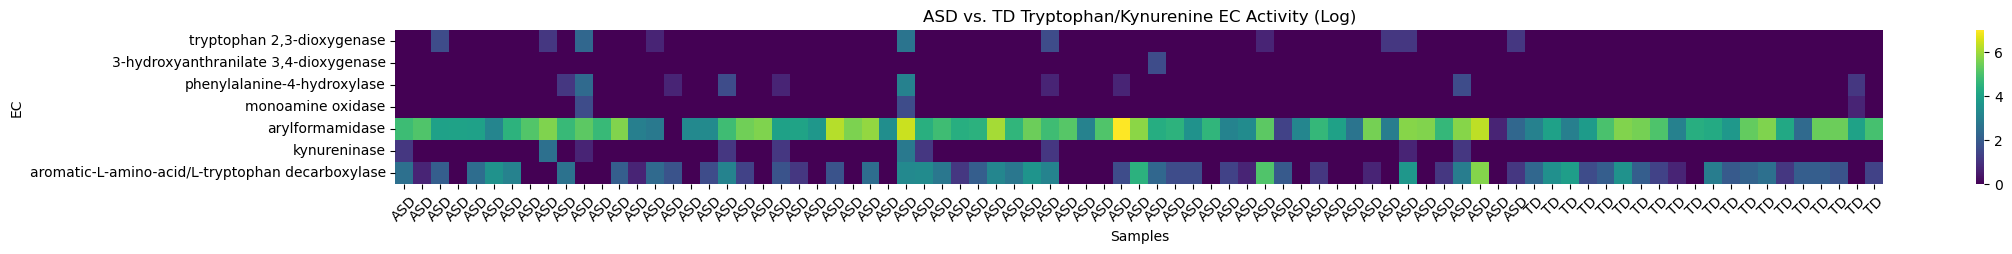

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Log-transform the data to handle zeros
logged_df = np.log1p(sorted_filtered_ec_df)

# Retrieve the 'EC' values for the columns and match them to the default index in info
column_labels = info.loc[info['EC'].isin(logged_df.columns)].index

# Retrieve the 'dx' values for the rows
row_labels = metadata_df.loc[logged_df.index, 'dx']

# Ensure the order of column labels matches the logged_df columns
column_labels = [info[info['EC'] == col].index[0] for col in logged_df.columns]

# Transpose the DataFrame for the heatmap
transposed_logged_df = logged_df.T

# Retrieve the transposed labels
transposed_row_labels = column_labels  # Now the columns become rows
transposed_column_labels = row_labels  # Now the rows become columns

# Create the heatmap with annotations
plt.figure(figsize=(24, 2))  # Adjusted figure size for the transposed heatmap
sns.heatmap(transposed_logged_df, cmap="viridis", cbar=True,
            xticklabels=transposed_column_labels, yticklabels=transposed_row_labels)

plt.title("ASD vs. TD Tryptophan/Kynurenine EC Activity (Log)")
plt.xlabel("Samples")
plt.ylabel("EC")
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.show()

### RCLR

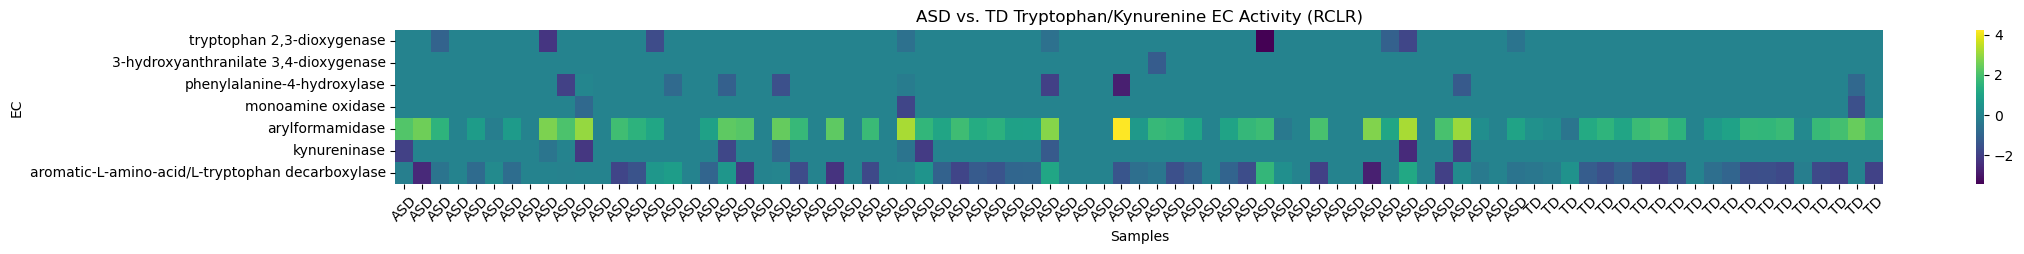

Shape of the data: (83, 7)
Number of NaN values after replacement: 0
Min value: -3.4315502919778105
Max value: 4.210238667681556


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gemelli.preprocessing import matrix_rclr

# Apply RCLR transformation using gemelli's matrix_rclr function
rclr_df = pd.DataFrame(
    matrix_rclr(sorted_filtered_ec_df.values),
    index=sorted_filtered_ec_df.index,
    columns=sorted_filtered_ec_df.columns
)

# Replace NaN values with 0
rclr_df = rclr_df.fillna(0)

# Retrieve the 'EC' values for the columns and match them to the default index in info
column_labels = info.loc[info['EC'].isin(rclr_df.columns)].index

# Retrieve the 'dx' values for the rows
row_labels = metadata_df.loc[rclr_df.index, 'dx']

# Ensure the order of column labels matches the rclr_df columns
column_labels = [info[info['EC'] == col].index[0] for col in rclr_df.columns]

# Transpose the DataFrame for the heatmap
transposed_rclr_df = rclr_df.T

# Retrieve the transposed labels
transposed_row_labels = column_labels  # Now the columns become rows
transposed_column_labels = row_labels  # Now the rows become columns

# Create the heatmap with annotations
plt.figure(figsize=(24, 2))  # Adjusted figure size for the transposed heatmap
sns.heatmap(transposed_rclr_df, cmap="viridis", cbar=True,
            xticklabels=transposed_column_labels, yticklabels=transposed_row_labels)
plt.title("ASD vs. TD Tryptophan/Kynurenine EC Activity (RCLR)")
plt.xlabel("Samples")
plt.ylabel("EC")
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.show()

# Print some diagnostic information
print(f"Shape of the data: {rclr_df.shape}")
print(f"Number of NaN values after replacement: {rclr_df.isna().sum().sum()}")
print(f"Min value: {rclr_df.min().min()}")
print(f"Max value: {rclr_df.max().max()}")

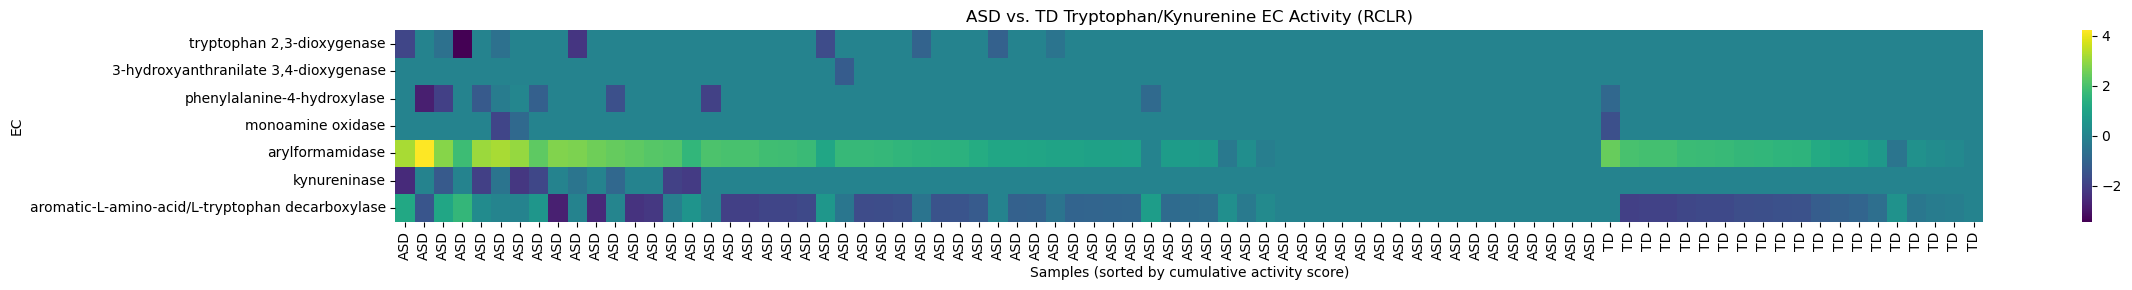

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gemelli.preprocessing import matrix_rclr

# Apply RCLR transformation using gemelli's matrix_rclr function
rclr_df = pd.DataFrame(
    matrix_rclr(sorted_filtered_ec_df.values),
    index=sorted_filtered_ec_df.index,
    columns=sorted_filtered_ec_df.columns
)

# Replace NaN values with 0
rclr_df = rclr_df.fillna(0)

# Calculate cumulative activity score (using absolute values)
cumulative_score = rclr_df.abs().sum(axis=1)

# Add dx information and cumulative score to the DataFrame
rclr_df['dx'] = metadata_df.loc[rclr_df.index, 'dx']
rclr_df['cumulative_score'] = cumulative_score

# Sort samples within each group (ASD and TD) by cumulative score
asd_samples = rclr_df[rclr_df['dx'] == 'ASD'].sort_values('cumulative_score', ascending=False)
td_samples = rclr_df[rclr_df['dx'] == 'TD'].sort_values('cumulative_score', ascending=False)

# Combine sorted ASD and TD samples
sorted_rclr_df = pd.concat([asd_samples, td_samples])

# Remove auxiliary columns before transposing
sorted_rclr_df = sorted_rclr_df.drop(['dx', 'cumulative_score'], axis=1)

# Transpose the DataFrame for the heatmap
transposed_rclr_df = sorted_rclr_df.T

# Retrieve the 'EC' values for the rows (former columns)
row_labels = [info[info['EC'] == col].index[0] for col in transposed_rclr_df.index]

# Retrieve the 'dx' values for the rows
row_labels_plot = metadata_df.loc[rclr_df.index, 'dx']

# Create the heatmap
plt.figure(figsize=(24, 3))  # Adjusted figure size for the transposed heatmap
sns.heatmap(transposed_rclr_df, cmap="viridis", cbar=True,
            xticklabels=row_labels_plot, yticklabels=row_labels)


# Customize the plot
plt.title("ASD vs. TD Tryptophan/Kynurenine EC Activity (RCLR)")
plt.xlabel("Samples (sorted by cumulative activity score)")
plt.ylabel("EC")

plt.tight_layout()
plt.show()

## ASD vs. ASD-TP

In [45]:
# Creating cumulative true positive score
metadata = md.to_dataframe()

# Filter for ASD cases first
asd_metadata = metadata[metadata['dx'] == 'ASD'].copy()

# Creating a df that indicates whether the sample is TP in one or more of the eye-tracking metrics
dx_eyetrack = pd.DataFrame(index=asd_metadata.index)
dx_eyetrack['dx_eyetrack'] = asd_metadata[['dx_compsocial', 'dx_geopref', 'dx_mtrtechno', 'dx_mtrtraffic', 'dx_outdoorplay']].apply(lambda x: 1 if 'TP' in x.values else 0, axis=1)

# Joining the dx_eyetrack DataFrame with the asd_metadata DataFrame
md_tp = asd_metadata.join(dx_eyetrack)

# Renaming labels in dx_eyetrack
md_tp['dx_eyetrack'] = md_tp['dx_eyetrack'].map({1: 'ASD-TP', 0: 'ASD'})

metadata_df = md_tp

# Display the value counts of the updated dx_eyetrack column
print(md_tp['dx_eyetrack'].value_counts())
print(metadata['dx'].value_counts())

ASD       34
ASD-TP    29
Name: dx_eyetrack, dtype: int64
ASD    63
TD     20
Name: dx, dtype: int64


<Figure size 1200x1000 with 0 Axes>

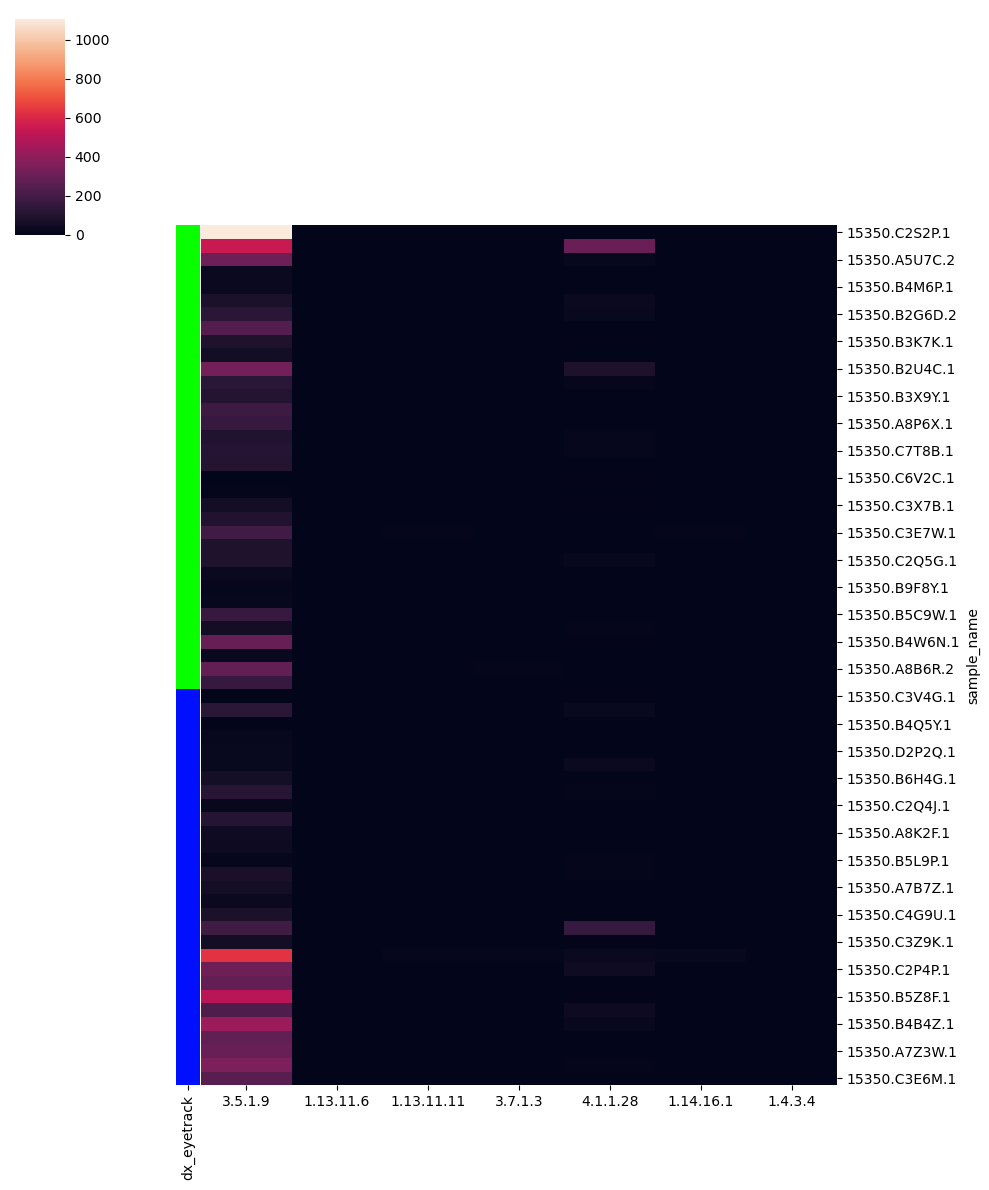

In [46]:
# Load BIOM tables from the given paths
ec_tp = biom.load_table('/home/lpatel/projects/2024-03-04_pierce-autism/out/195333_ec.zebra.tp-td.biom')
ec = biom.load_table('/home/lpatel/projects/2024-03-04_pierce-autism/out/195333_ec.zebra.biom')

# Convert the EC column values to a set for faster lookup
ec_info_values = set(info["EC"].values)

# Get the observation IDs from the BIOM table `ec`
ec_observation_ids = set(ec.ids(axis='observation'))

# Find the overlap
overlap = ec_info_values.intersection(ec_observation_ids)

# Filter the `ec` table to include only the overlapping observations
filtered_ec = ec.filter(overlap, axis='observation', inplace=False)

# Convert the filtered BIOM table to a DataFrame
filtered_ec_df = filtered_ec.to_dataframe(dense=True).T

# Filter metadata_df to include only samples present in filtered_ec_df
metadata_df_filtered = metadata_df[metadata_df.index.isin(filtered_ec_df.index)]

# Sort rows by 'dx_eyetrack'
sorted_metadata_df = metadata_df_filtered.sort_values('dx_eyetrack')
sorted_filtered_ec_df = filtered_ec_df.loc[sorted_metadata_df.index]

# Define clusters for rows (samples) within each 'dx' group
def cluster_within_groups(df, group_labels):
    sorted_idx = []
    unique_groups = group_labels.unique()
    for group in unique_groups:
        group_idx = group_labels[group_labels == group].index
        group_data = df.loc[group_idx]
        if len(group_idx) > 1:  # Only cluster if there's more than one sample
            kmeans = KMeans(n_clusters=2, random_state=0).fit(group_data)
            sorted_idx.extend(group_idx[np.argsort(kmeans.labels_)])
        else:
            sorted_idx.extend(group_idx)
    return sorted_idx

row_clusters = cluster_within_groups(sorted_filtered_ec_df, sorted_metadata_df["dx_eyetrack"])

# Group columns by 'Tryptophan Pathway' and sort within each group
grouped_columns = info.set_index('EC').loc[filtered_ec_df.columns, "Tryptophan Pathway"]
unique_pathways = grouped_columns.unique()
sorted_col_idx = []
for pathway in unique_pathways:
    pathway_cols = grouped_columns[grouped_columns == pathway].index
    pathway_data = filtered_ec_df[pathway_cols]
    if len(pathway_cols) > 1:  # Only cluster if there's more than one column
        col_linkage = linkage(pathway_data.T, method='ward')
        sorted_col_idx.extend(pathway_cols[leaves_list(col_linkage)])
    else:
        sorted_col_idx.extend(pathway_cols)

# Reorder the DataFrame using .loc for label-based indexing
reordered_df = sorted_filtered_ec_df.loc[row_clusters, sorted_col_idx]

# Relabel the x-axis using the original index names from info
info_indexed = info.set_index('EC')
column_labels = info_indexed.loc[reordered_df.columns].index
reordered_df.columns = column_labels

# Map the "dx_eyetrack" column to colors
unique_dx = sorted_metadata_df["dx_eyetrack"].unique()
color_palette = sns.color_palette("hsv", len(unique_dx))
dx_colors = dict(zip(unique_dx, color_palette))
row_colors = sorted_metadata_df["dx_eyetrack"].map(dx_colors).loc[row_clusters]

# Generate the cluster map
plt.figure(figsize=(12, 10))
sns.clustermap(reordered_df, row_cluster=False, col_cluster=False, figsize=(10, 12), row_colors=row_colors)
plt.show()

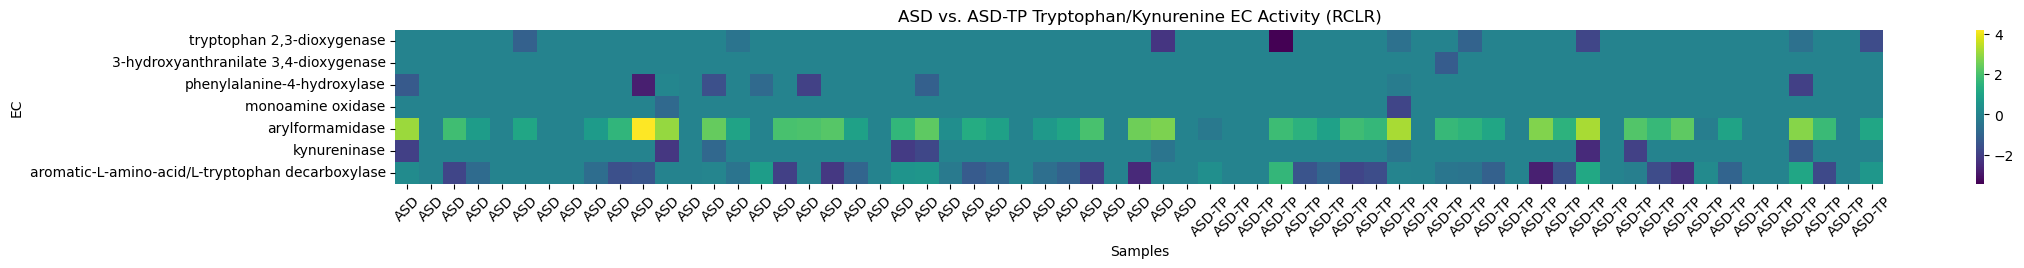

Shape of the data: (63, 7)
Number of NaN values after replacement: 0
Min value: -3.4315502919778105
Max value: 4.210238667681556


In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gemelli.preprocessing import matrix_rclr

# Apply RCLR transformation using gemelli's matrix_rclr function
rclr_df = pd.DataFrame(
    matrix_rclr(sorted_filtered_ec_df.values),
    index=sorted_filtered_ec_df.index,
    columns=sorted_filtered_ec_df.columns
)

# Replace NaN values with 0
rclr_df = rclr_df.fillna(0)

# Retrieve the 'EC' values for the columns and match them to the default index in info
column_labels = info.loc[info['EC'].isin(rclr_df.columns)].index

# Retrieve the 'dx_eyetrack' values for the rows
row_labels = metadata_df.loc[rclr_df.index, 'dx_eyetrack']

# Ensure the order of column labels matches the rclr_df columns
column_labels = [info[info['EC'] == col].index[0] for col in rclr_df.columns]

# Transpose the DataFrame for the heatmap
transposed_rclr_df = rclr_df.T

# Retrieve the transposed labels
transposed_row_labels = column_labels  # Now the columns become rows
transposed_column_labels = row_labels  # Now the rows become columns

# Create the heatmap with annotations
plt.figure(figsize=(24, 2))  # Adjusted figure size for the transposed heatmap
sns.heatmap(transposed_rclr_df, cmap="viridis", cbar=True,
            xticklabels=transposed_column_labels, yticklabels=transposed_row_labels)
plt.title("ASD vs. ASD-TP Tryptophan/Kynurenine EC Activity (RCLR)")
plt.xlabel("Samples")
plt.ylabel("EC")
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.show()

# Print some diagnostic information
print(f"Shape of the data: {rclr_df.shape}")
print(f"Number of NaN values after replacement: {rclr_df.isna().sum().sum()}")
print(f"Min value: {rclr_df.min().min()}")
print(f"Max value: {rclr_df.max().max()}")

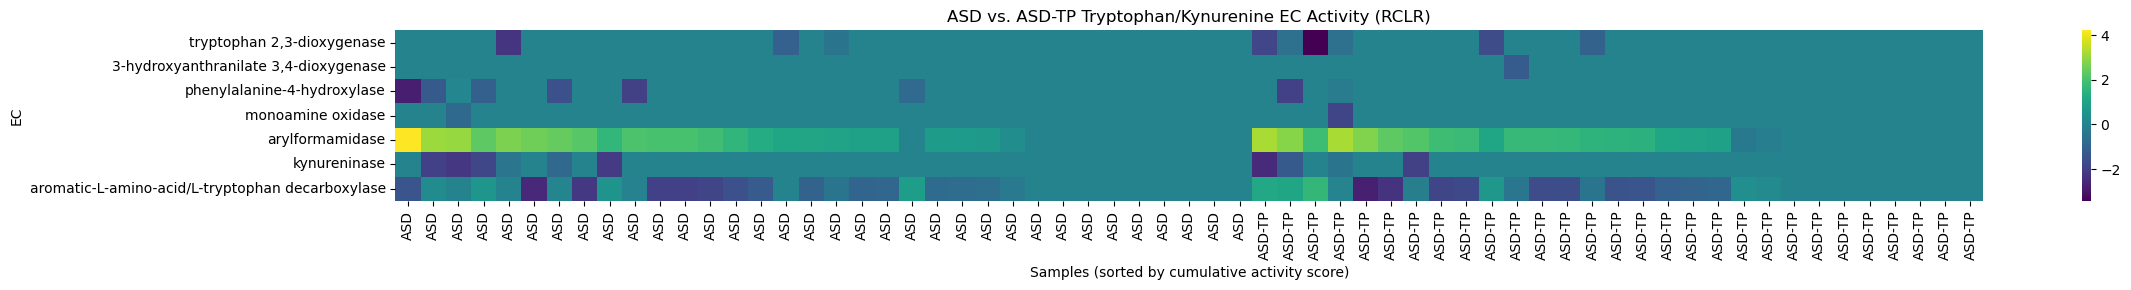

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gemelli.preprocessing import matrix_rclr

# Apply RCLR transformation using gemelli's matrix_rclr function
rclr_df = pd.DataFrame(
    matrix_rclr(sorted_filtered_ec_df.values),
    index=sorted_filtered_ec_df.index,
    columns=sorted_filtered_ec_df.columns
)

# Replace NaN values with 0
rclr_df = rclr_df.fillna(0)

# Calculate cumulative activity score (using absolute values)
cumulative_score = rclr_df.abs().sum(axis=1)

# Add dx_eyetrack information and cumulative score to the DataFrame
rclr_df['dx_eyetrack'] = metadata_df.loc[rclr_df.index, 'dx_eyetrack']
rclr_df['cumulative_score'] = cumulative_score

# Sort samples within each group (ASD and TP) by cumulative score
asd_samples = rclr_df[rclr_df['dx_eyetrack'] == 'ASD'].sort_values('cumulative_score', ascending=False)
tp_samples = rclr_df[rclr_df['dx_eyetrack'] == 'ASD-TP'].sort_values('cumulative_score', ascending=False)

# Combine sorted ASD and TD samples
sorted_rclr_df = pd.concat([asd_samples, tp_samples])

# Remove auxiliary columns before transposing
sorted_rclr_df = sorted_rclr_df.drop(['dx_eyetrack', 'cumulative_score'], axis=1)

# Transpose the DataFrame for the heatmap
transposed_rclr_df = sorted_rclr_df.T

# Retrieve the 'EC' values for the rows (former columns)
row_labels = [info[info['EC'] == col].index[0] for col in transposed_rclr_df.index]

# Retrieve the 'dx' values for the rows
row_labels_plot = metadata_df.loc[rclr_df.index, 'dx_eyetrack']

# Create the heatmap
plt.figure(figsize=(24, 3))  # Adjusted figure size for the transposed heatmap
sns.heatmap(transposed_rclr_df, cmap="viridis", cbar=True,
            xticklabels=row_labels_plot, yticklabels=row_labels)


# Customize the plot
plt.title("ASD vs. ASD-TP Tryptophan/Kynurenine EC Activity (RCLR)")
plt.xlabel("Samples (sorted by cumulative activity score)")
plt.ylabel("EC")

plt.tight_layout()
plt.show()